# 数据读取

In [5]:
import pandas as pd
import numpy as np

base_path = '/home/liyouru/.ipython/profile_myserver/dataset/KDD_Cup2018/'

p_bj_aq = '/home/lifuzhen/KDD2018/beijing_17_18_aq.csv'
p_bj_aq_lfz = '/home/lifuzhen/KDD2018/Fill_v1_undrop.csv'
p_bj_aq_2_3_lfz = '/home/lifuzhen/KDD2018/Fill0203_v1_undrop.csv'
p_bj_aq_full = base_path + 'beijing_17_18_aq_full.csv'
p_bj_aq_2_3 = base_path + 'beijing_201802_201803_aq.csv'
p_bj_aq_2_3_full = base_path + 'beijing_201802_201803_aq_full.csv'


p_bj_meo = base_path + 'beijing_17_18_meo_full.csv'
p_ld_aq1 = base_path + 'London_historical_aqi_forecast_stations_20180331.csv'
p_ld_aq2 = base_path + 'London_historical_aqi_other_stations_20180331.csv'

# *****************
bj_input_path = base_path + 'daily_data/bj_aq/m_04_60.csv'
ld_input_path = base_path + 'daily_data/ld_aq/m_04_60.csv'
# *****************

df_bj_aq = pd.read_csv(bj_input_path)
df_bj_aq_2_3 = pd.read_csv(p_bj_aq_2_3)
df_bj_meo = pd.read_csv(p_bj_meo)
df_ld_aq1 = pd.read_csv(p_ld_aq1)
df_ld_aq2 = pd.read_csv(p_ld_aq2)

# 北京空气质量数据缺失值填补

* 利用空间关系进行邻域填补：寻求最近邻监测点数据作为替代，若同缺失则扩大近邻选取范围
* 利用时间关系进行邻域填补：取缺失位置临近时间的空气质量值作为替代

# 统计空间近邻关系

In [6]:
def get_map(n_city):
    n_pos = 0
    if n_city == 1:
        p_bj_pos = base_path + 'bj_station_position.csv'
        df_bj_pos = pd.read_csv(p_bj_pos)
        b_stationId = list(df_bj_pos['stationId'])
        b_longitude = list(df_bj_pos['longitude'])
        b_latitude = list(df_bj_pos['latitude'])
        b_type = list(df_bj_pos['type'])
        n_pos = 35
    else:
        p_bj_pos = base_path + 'london_station_position.csv'
        df_bj_pos = pd.read_csv(p_bj_pos)
        b_stationId = list(df_bj_pos['Station_id'])
        b_longitude = list(df_bj_pos['Longitude'])
        b_latitude = list(df_bj_pos['Latitude'])
        b_type = []
        for i in range(len(b_latitude)):
            b_type.append(1)
        df_bj_pos = pd.read_csv(p_bj_pos)
        n_pos = 13
    
    # 计算相对距离
    distance = []
    neibour = []
    for i in range(13):
        temp = []

        # 计算相对距离
        index = []
        for j in range(n_pos):
            index.append(j)
        del index[i]
        for k in range(len(index)):
            temp.append(pow(b_longitude[i] - b_longitude[index[k]],2) + pow(b_latitude[i] - b_latitude[index[k]],2) + pow(b_type[i] - b_type[index[k]],2))
        distance.append(temp)
        # 判定最近邻
        s_distance = sorted(temp)
        t_neibour = []
        for j in range(12):
            t_index = temp.index(s_distance[j])
            if t_index < i:
                t_neibour.append(b_stationId[t_index])
            else:
                t_neibour.append(b_stationId[t_index + 1])
            neibour.append(t_neibour)

    # 得到最佳替补对
    best_pair4full = {}
    for i in range(n_pos):
        for j in range(12):
            best_pair4full.setdefault(b_stationId[i],[]).append(neibour[i][j])
    return best_pair4full
best_pair4full = get_map(1)

# 时空关系补全

In [7]:
from tqdm import tqdm
import datetime

# 对北京空气质量数据建立时空关系映射
bj_aq_map = {}
b_aq_id = list(df_bj_aq['stationId'])
b_aq_time = list(df_bj_aq['utc_time'])
b_aq_pm25 = list(df_bj_aq['PM2.5'])
b_aq_pm10 = list(df_bj_aq['PM10'])
b_aq_no2 = list(df_bj_aq['NO2'])
b_aq_co = list(df_bj_aq['CO'])
b_aq_o3 = list(df_bj_aq['O3'])
b_aq_so2 = list(df_bj_aq['SO2'])
data2full_index = [b_aq_pm25,b_aq_pm10,b_aq_no2,b_aq_co,b_aq_o3,b_aq_so2] 

# 伦敦
# b_aq_id = list(df_bj_aq['station_id'])
# b_aq_time = list(df_bj_aq['MeasurementDateGMT'])
# b_aq_pm25 = list(df_bj_aq['PM2.5 (ug/m3)'])
# b_aq_pm10 = list(df_bj_aq['PM10 (ug/m3)'])
# b_aq_no2 = list(df_bj_aq['NO2 (ug/m3)'])
# data2full_index = [b_aq_pm25,b_aq_pm10,b_aq_no2] 

for i in range(len(b_aq_id)):
    t_key = str(b_aq_id[i]) + str(b_aq_time[i]) 
    for each in data2full_index:
        bj_aq_map.setdefault(t_key,[]).append(each[i])

# 进行填补
t_pm25,t_pm10,t_no2,t_co,t_o3,t_so2 = list(),list(),list(),list(),list(),list()
t_index = [t_pm25,t_pm10,t_no2,t_co,t_o3,t_so2]
# t_index = [t_pm25,t_pm10,t_no2]
avg_fillna = [61,130,42,0.7,83,6]
# avg_fillna = [17,25,40]

for i in tqdm(range(len(b_aq_id))):
    for j in range(len(t_index)):
        # 无缺失填补
        if not np.isnan(data2full_index[j][i]):
            t_index[j].append(data2full_index[j][i])
        # 空间邻域填补
        elif bj_aq_map.has_key(str(best_pair4full[str(b_aq_id[i])][0]) + str(b_aq_time[i])):
            if not np.isnan(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][0]) + str(b_aq_time[i])][j]):
                t_index[j].append(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][0]) + str(b_aq_time[i])][j])
            elif bj_aq_map.has_key(str(best_pair4full[str(b_aq_id[i])][1]) + str(b_aq_time[i])):
                if not np.isnan(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][1]) + str(b_aq_time[i])][j]):
                    t_index[j].append(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][1]) + str(b_aq_time[i])][j])
                elif bj_aq_map.has_key(str(best_pair4full[str(b_aq_id[i])][2]) + str(b_aq_time[i])):
                    if not np.isnan(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][2]) + str(b_aq_time[i])][j]):
                        t_index[j].append(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][2]) + str(b_aq_time[i])][j])
                    elif bj_aq_map.has_key(str(best_pair4full[str(b_aq_id[i])][3]) + str(b_aq_time[i])):
                        if not np.isnan(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][3]) + str(b_aq_time[i])][j]):
                            t_index[j].append(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][3]) + str(b_aq_time[i])][j])
                        elif bj_aq_map.has_key(str(best_pair4full[str(b_aq_id[i])][4]) + str(b_aq_time[i])):
                            if not np.isnan(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][4]) + str(b_aq_time[i])][j]):
                                t_index[j].append(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][4]) + str(b_aq_time[i])][j])
                            elif bj_aq_map.has_key(str(best_pair4full[str(b_aq_id[i])][5]) + str(b_aq_time[i])):
                                if not np.isnan(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][5]) + str(b_aq_time[i])][j]):
                                    t_index[j].append(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][5]) + str(b_aq_time[i])][j])
                                elif bj_aq_map.has_key(str(best_pair4full[str(b_aq_id[i])][6]) + str(b_aq_time[i])):
                                    if not np.isnan(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][6]) + str(b_aq_time[i])][j]):
                                        t_index[j].append(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][6]) + str(b_aq_time[i])][j])
                                    elif bj_aq_map.has_key(str(best_pair4full[str(b_aq_id[i])][7]) + str(b_aq_time[i])):
                                        if not np.isnan(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][7]) + str(b_aq_time[i])][j]):
                                            t_index[j].append(bj_aq_map[str(best_pair4full[str(b_aq_id[i])][7]) + str(b_aq_time[i])][j])
                                        else:
                                            t_index[j].append(avg_fillna[j])
                                    else:
                                        t_index[j].append(avg_fillna[j])
                                else:
                                    t_index[j].append(avg_fillna[j])
                            else:
                                t_index[j].append(avg_fillna[j])
                        else:
                            t_index[j].append(avg_fillna[j])
                    else:
                        t_index[j].append(avg_fillna[j])
                else:
                    t_index[j].append(avg_fillna[j])
            else:
                t_index[j].append(avg_fillna[j])
        else:
            t_index[j].append(avg_fillna[j])

100%|██████████| 46725/46725 [00:00<00:00, 84243.25it/s]


# 写入文件

In [4]:
n_df_bj_aq = []
index = [b_aq_id,b_aq_time,t_pm25,t_pm10,t_no2,t_co,t_o3,t_so2]
# index = [b_aq_id,b_aq_time,t_pm25,t_pm10,t_no2]

for each in index:
    n_df_bj_aq.append(each)

c_index = ['stationId','utc_time','PM2.5','PM10','NO2','CO','O3','SO2']
# c_in/dex = ['stationId','utc_time','PM2.5','PM10','NO2']

df_bj_aq_full_s1 = pd.DataFrame(np.transpose(n_df_bj_aq) ,index = None, columns = c_index)
df_bj_aq_full_s1.to_csv(ld_input_path)
df_bj_aq_full_s1.tail()

,stationId,utc_time,PM2.5,PM10,NO2
18654,MY7,2018-05-30 19:00:00,28.5,33.0,63.1
18655,MY7,2018-05-30 20:00:00,31.4,37.8,36.9
18656,MY7,2018-05-30 21:00:00,34.8,41.9,70.2
18657,MY7,2018-05-30 22:00:00,41.5,49.7,76.7
18658,MY7,2018-05-30 23:00:00,50.5,64.7,77.5


# 统计补全效果

In [5]:
print '总量：'
print len(data2full_index[0])

c1 = [0,0,0,0,0,0]
for i in range(len(data2full_index)):
    for j in range(len(data2full_index[i])):
        if np.isnan(data2full_index[i][j]):
            c1[i] += 1
print '填补前缺量：'
print 'PM2.5  PM10  NO2  O3  CO  O3  SO2'
print c1[0],c1[1],c1[2],c1[3],c1[4],c1[5]

print '填补后缺量：'
print 'PM2.5  PM10  NO2  O3  CO  O3  SO2'
c2 = [0,0,0,0,0,0]

for i in range(len(t_pm25)):
    for j in range(3):
        if np.isnan(t_index[j][i]):
            c2[j] += 1
        
print c2[0],' ',c2[1],' ',c2[2],' ',c2[3],' ',c2[4],' ',c2[5]

总量：
11795
填补前缺量：
PM2.5  PM10  NO2  O3  CO  O3  SO2
2296 1734 2637 0 0 0
填补后缺量：
PM2.5  PM10  NO2  O3  CO  O3  SO2
0   0   0   0   0   0


# 缺失分布可视化

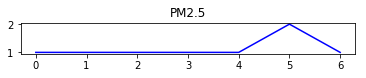

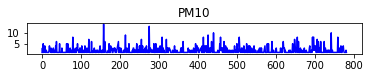

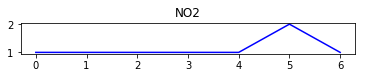

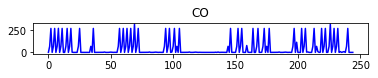

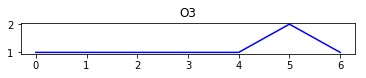

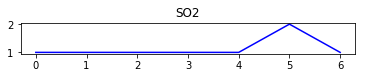

In [406]:
import matplotlib.pyplot as plt

data = [t_pm25,t_pm10,t_no2]
duration = []

for each in t_index:
    duration_temp = []
    temp = 0
    for i in range(len(each)):
        if np.isnan(each[i]):
            temp += 1
        else:
            if temp != 0:
                duration_temp.append(temp)
                temp = 0
    duration.append(duration_temp)

name = ['PM2.5','PM10','NO2','CO','O3','SO2']
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(duration[i],'b')
    plt.title(name[i])
    plt.show()